### Machine Learning with Big Data
## Part 2: Convolutional Neural Networks

# 0.6 - Early Stopping

**Group:** MLBD_Deventer 4   
**Students:** Mathijs Pattipeilohy (512391), Emin Fikret (511275)

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

from joblib import load

2025-10-25 16:45:08.069482: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-25 16:45:08.098269: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-25 16:45:08.321960: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-25 16:45:09.638462: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
SEED = 42
EPOCHS = 10
BATCH  = 32 # default

tf.keras.utils.set_random_seed(SEED)

In [3]:
ARTIFACTS_DIR = "../artifacts"
MODEL_NAME = "cnn_early_stopping"

INPUT_FILE = os.path.join(ARTIFACTS_DIR, "images_tuple.joblib")

LOG_DIR   = os.path.join(ARTIFACTS_DIR, "logs", f"{MODEL_NAME}")
MODEL_FILE = os.path.join(ARTIFACTS_DIR, f"{MODEL_NAME}.keras")
CKPT_FILE  = os.path.join(ARTIFACTS_DIR, f"best_{MODEL_NAME}.keras")

In [4]:
(
    X_train, X_val, X_test,
    y_train, y_val, y_test,
    classes
) = load(INPUT_FILE)

num_classes = len(classes)
print("Classes:", classes)
print("Train shape:", X_train.shape, y_train.shape)

Classes: ['az', 'dobro', 'estb', 'frbtb', 'ize', 'jatb', 'ljudie', 'nasb', 'sa', 'sta', 'ukb', 'vede']
Train shape: (900, 128, 128, 4) (900, 12)


### Recap

In the previous version, we added dropout layers to reduce overfitting, which improved generalization and validation stability.

The model still trained for all 10 epochs, even after the validation loss stopped improving near the end.

In this version, we enable early stopping to automatically stop training when validation loss no longer improves.

## Model: Early Stopping

The model architecture stays the same as in the dropout version.

We only uncomment the EarlyStopping callback, which ensures the model reverts to the weights of the best-performing epoch.

This helps prevent overfitting in later epochs and shortens training time while keeping the best result.

In [5]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=X_train.shape[1:]),
    tf.keras.layers.Rescaling(1.0 / 255), # min-max scale rbg values

    tf.keras.layers.Conv2D(
        32, (3,3), 
        activation="relu",
        padding="same", # add zeros around the edges
    ), # learns low-level features, like edges
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.25), # low regularization
    
    tf.keras.layers.Conv2D(
        64, (3,3), 
        activation="relu",
        padding="same", # add zeros around the edges
    ), # learns higher-lever combinations, like shapes
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.25), # mid regularization
    
    tf.keras.layers.Flatten(), # turns 2d features into 1d vector
    tf.keras.layers.Dropout(0.5), # high regularization
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(), # variation of gradient descent
    loss=tf.keras.losses.CategoricalCrossentropy(),
    # we could have just used accuracy, 
    # it would have fallen back to categorical accuracy
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │       786,444 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 806,124 (3.08 MB)

 Trainable params: 806,124 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR),
    # if val_loss does not get better after 3 epochs, 
    # stop training and get the best model weights
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=3, restore_best_weights=True
    ),
    # save best model
    tf.keras.callbacks.ModelCheckpoint(
        CKPT_FILE, monitor="val_categorical_accuracy", save_best_only=True
    )
]

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH,
    shuffle=True,
    validation_data=(X_val, y_val),
    # or we could have used "validation_set" param
    callbacks=callbacks,
    verbose=2,
)

Epoch 1/10


2025-10-25 16:45:14.296760: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 235929600 exceeds 10% of free system memory.
2025-10-25 16:45:15.731575: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 67108864 exceeds 10% of free system memory.
2025-10-25 16:45:15.806132: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16777216 exceeds 10% of free system memory.
2025-10-25 16:45:15.826221: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16777216 exceeds 10% of free system memory.
2025-10-25 16:45:15.826289: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16777216 exceeds 10% of free system memory.


29/29 - 11s - 392ms/step - categorical_accuracy: 0.4689 - loss: 1.8820 - val_categorical_accuracy: 0.8256 - val_loss: 0.5359
Epoch 2/10
29/29 - 10s - 354ms/step - categorical_accuracy: 0.8833 - loss: 0.3499 - val_categorical_accuracy: 0.8876 - val_loss: 0.3383
Epoch 3/10
29/29 - 12s - 420ms/step - categorical_accuracy: 0.9500 - loss: 0.1547 - val_categorical_accuracy: 0.8876 - val_loss: 0.2947
Epoch 4/10
29/29 - 16s - 558ms/step - categorical_accuracy: 0.9678 - loss: 0.1080 - val_categorical_accuracy: 0.8760 - val_loss: 0.3408
Epoch 5/10
29/29 - 14s - 496ms/step - categorical_accuracy: 0.9700 - loss: 0.0786 - val_categorical_accuracy: 0.8992 - val_loss: 0.3046
Epoch 6/10
29/29 - 12s - 426ms/step - categorical_accuracy: 0.9767 - loss: 0.0690 - val_categorical_accuracy: 0.9031 - val_loss: 0.3553


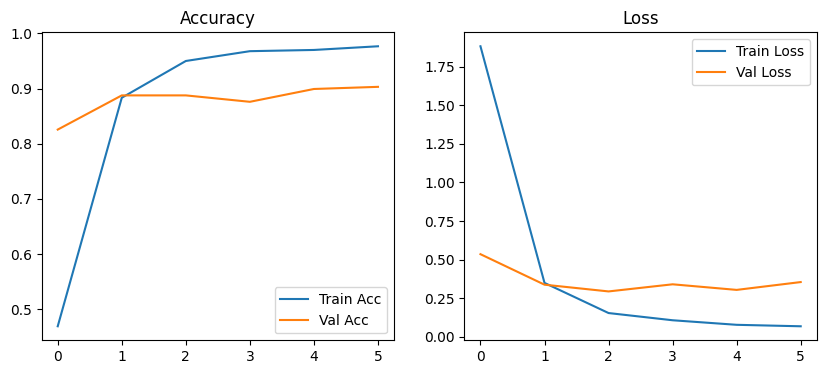

In [7]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['categorical_accuracy'], label='Train Acc')
plt.plot(history.history['val_categorical_accuracy'], label='Val Acc')
plt.title('Accuracy'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss'); plt.legend()

plt.show()

In [8]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - categorical_accuracy: 0.8719 - loss: 0.5175
Test accuracy: 0.8672


### Results: Early Stopping

With early stopping enabled, training stopped automatically when the validation loss stopped improving.
This helped avoid unnecessary epochs and prevented further overfitting in later stages.

Although the final test accuracy was slightly lower than the dropout version, the training and validation curves became smoother and stayed closer together, showing improved stability and generalization.

This confirms that the model reached its optimal point earlier and maintained consistent performance.

-----

### Next steps

In the next version, we will introduce data augmentation to expose the model to more visual variations of the same symbols.

This is expected to improve accuracy without increasing overfitting.

-----

### References:
- https://www.geeksforgeeks.org/deep-learning/using-early-stopping-to-reduce-overfitting-in-neural-networks/